<a href="https://colab.research.google.com/github/ernestcr/100_Days_of_ML_Code/blob/master/ECR%20Rt_Huayno_deriving_daily_new_cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# AmigoCloud (http://www.amigocloud.com) standard GIS dependencies
# Ubuntu GIS
!add-apt-repository ppa:ubuntugis/ubuntugis-unstable -y
!apt-get install gdal-bin
!ogrinfo --version
!pip install amigocloud

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/ubuntugis/ubuntugis-unstable/ubuntu bionic InRelease
Reading package lists... Done
Reading package li

# Basado altamente en el approach descrito por los fundadores de Instagram
https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb

# Más las contribuciones del equipo de Brasil de Loft, aquí. Please give
# some love to those guys.
https://github.com/loft-br/realtime_r0_brazil



In [0]:
# general imports
import numpy as np
import pandas as pd
import datetime as dt

# matplotlib
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# scipy specifics
from scipy import stats as sps
from scipy.interpolate import interp1d


# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# best sigma for Perú (prior hyperparameters)
#OPTIMAL_SIGMA = 0.35 # through Kevin's Optimization
OPTIMAL_SIGMA = 0.01

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

In [0]:
import requests


def download_data_from_server():

    """
    Downloads data from Peruvian govt servers
    """

    # I have rewritten this so many times to change servers, I am just tired of it
    # First, I put some love to this function, but now, it is just "a la mala"

    # download data from geocatmin, however, the "beauty" of it is that for some reason
    # paging is not supported - so I have to simulate it (UGH)

    lower_idx = 0
    offset_size = 500

    # get record count
    response = requests.get('https://geocatmin.ingemmet.gob.pe/arcgis/rest/services/COVIT_PERU_REGION/MapServer/1/query?where=1%3D1&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=FECHA%2CREGION%2CCONFIRMADOS&returnGeometry=false&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&having=&returnIdsOnly=false&returnCountOnly=true&orderByFields=OBJECTID+ASC&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&featureEncoding=esriDefault&f=pjson')
    count = int(response.json()['count'])

    # start paging. remember geodatabase ids start at 0.
    # this will only work of geodatabase ids are sequential. If this changes, 
    # then we need to change the approach to count on every request. Not doing that yet.

    !rm peru_data_raw.sqlite || true

    while lower_idx + offset_size < (count + offset_size):
      filter = "objectid > " + str(lower_idx) + " and objectid <= " + str(lower_idx + offset_size)
      #print(filter)
      filter_encoded = requests.utils.quote(filter)
      geocatmin_query_url = "https://geocatmin.ingemmet.gob.pe/arcgis/rest/services/COVIT_PERU_REGION/MapServer/1/query?where=" + filter_encoded + "&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=FECHA,REGION,CONFIRMADOS&returnGeometry=false&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&having=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&featureEncoding=esriDefault&f=geojson"
      
      !ogr2ogr -append -f "SQLITE" peru_data_raw.sqlite "$geocatmin_query_url"
      
      lower_idx = lower_idx + offset_size

    # convert to CSV to continue pipeline
    !ogr2ogr -f CSV peru_data_raw.csv peru_data_raw.sqlite

    # check that record counts match
    if count != (len(open('peru_data_raw.csv').readlines()) - 1):
      raise ValueError('Sorry buddy, need to change paging code')


def load_data():

    """
    Loads state data from Peruvian servers
    Returns
    ----------
    state_df: state data (Perú)
    """

    download_data_from_server()

    # clean dates into something decent and save it to file to check results if necessary
    from datetime import date
    depts_raw = pd.read_csv('peru_data_raw.csv')
    depts_raw['fecha'] = depts_raw['fecha'].apply(lambda x: date.fromtimestamp(float(x)/1000))
    depts_raw.to_csv('peru_data_clean.csv')
    
    # manipulate in numpy, because I am too dumb and lazy to look up pandas APIs and just want to get it done
    sorted_regions = (depts_raw.sort_values(['region', 'fecha'], ascending=[True, True])).to_numpy()

    # the values shown in "CONFIRMADOS" is *total* for that area. 
    # We have to subtract values with the previous day to get 
    # new confirmed

    new_region_values = np.copy(sorted_regions)

    current_region = ""

    for i in range(0, len(sorted_regions)):
  
      if current_region != sorted_regions[i][1]:
        # changed regions and this is the first row
        # we don't need to process that one
        current_region = sorted_regions[i][1]
        print('Cleaning ' + current_region)
        continue
  
      new_confirmados = sorted_regions[i][2] - sorted_regions[i-1][2]
      if new_confirmados < 0:
        new_confirmados = 0

      new_region_values[i][2] = new_confirmados

    # build back de pandas dataframe so we can save it.
    df = pd.DataFrame(data=new_region_values, index=depts_raw.index, columns=depts_raw.columns)
    df.to_csv('peru_data_clean.csv')

    # If you read this and think it is inneficient, you are completely correct!
    # The reason it is structured like this is that this has been broken
    # many times and I always have had to save the file to check it at different
    # stages of the pipeline.

    state_df = (
                pd.read_csv('peru_data_clean.csv', parse_dates=['fecha'])
                .rename(columns={'confirmados': 'confirmed_new',
                                 'fecha': 'date',
                                 'region' : 'state'})               
                .groupby(['state','date']).sum()
            )


    return state_df

In [0]:
def smooth_new_cases(new_cases):
    
    """
    Function to apply gaussian smoothing to cases
    Arguments
    ----------
    new_cases: time series of new cases
    Returns 
    ----------
    smoothed_cases: cases after gaussian smoothing
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    smoothed_cases = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed_cases.index[smoothed_cases.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed_cases.index.get_loc(last_zero) + 1
    smoothed_cases = smoothed_cases.iloc[idx_start:]
    original = new_cases.loc[smoothed_cases.index]
    
    return original, smoothed_cases


def calculate_posteriors(sr, sigma=0.15):

    """
    Function to calculate posteriors of Rt over time
    Arguments
    ----------
    sr: smoothed time series of new cases
    sigma: gaussian noise applied to prior so we can "forget" past observations
           works like exponential weighting
    Returns 
    ----------
    posteriors: posterior distributions
    log_likelihood: log likelihood given data
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood


def highest_density_interval(pmf, p=.9):

    """
    Function to calculate highest density interval 
    from posteriors of Rt over time
    Arguments
    ----------
    pmf: posterior distribution of Rt
    p: mass of high density interval
    Returns 
    ----------
    interval: expected value and density interval
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    most_likely = pmf.idxmax()

    interval = pd.Series([most_likely, low, high], index=['ML',f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

    return interval


def plot_rt(result, ax, state_name):
    
    """
    Function to plot Rt
    Arguments
    ----------
    result: expected value and HDI of posterior
    ax: matplotlib axes 
    state_name: state to be considered
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1)) 


def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    
    """
    Function to plot standings
    Arguments
    ----------
    mr: results by state
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """


    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize, dpi=150)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=[.7,.7,.7],
                  ecolor=[.3,.3,.3],
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)


    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,4.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)


    fig.set_facecolor('w')
    return fig, ax

def run_full_model(cases, sigma=OPTIMAL_SIGMA):

    # initializing result dict
    result = {''}

    # smoothing series
    new, smoothed = smooth_new_cases(cases)

    # calculating posteriors
    posteriors, log_likelihood = calculate_posteriors(smoothed, sigma=sigma)

    # calculating HDI
    result = highest_density_interval(posteriors, p=.9)

    return result

In [0]:
# Correr Modelo

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from joblib import Parallel, delayed

# core count to parallelize job
N_JOBS = -1

### reading data ###

state_df = load_data()

# There is only "confirmados", so let's just use that
state_df = state_df['confirmed_new']

rm: cannot remove 'peru_data_raw.sqlite': No such file or directory
Cleaning AMAZONAS
Cleaning ANCASH
Cleaning APURIMAC
Cleaning AREQUIPA
Cleaning AYACUCHO
Cleaning CAJAMARCA
Cleaning CALLAO
Cleaning CUSCO
Cleaning HUANCAVELICA
Cleaning HUANUCO
Cleaning ICA
Cleaning JUNIN
Cleaning LA LIBERTAD
Cleaning LAMBAYEQUE
Cleaning LIMA
Cleaning LORETO
Cleaning MADRE DE DIOS
Cleaning MOQUEGUA
Cleaning PASCO
Cleaning PIURA
Cleaning PUNO
Cleaning SAN MARTIN
Cleaning TACNA
Cleaning TUMBES
Cleaning UCAYALI


In [0]:
### running posteriors ###

with Parallel(n_jobs=N_JOBS) as parallel:
    results = parallel(delayed(run_full_model)(grp[1], sigma=0.01) for grp in state_df.groupby(level='state'))

final_results = pd.concat(results)

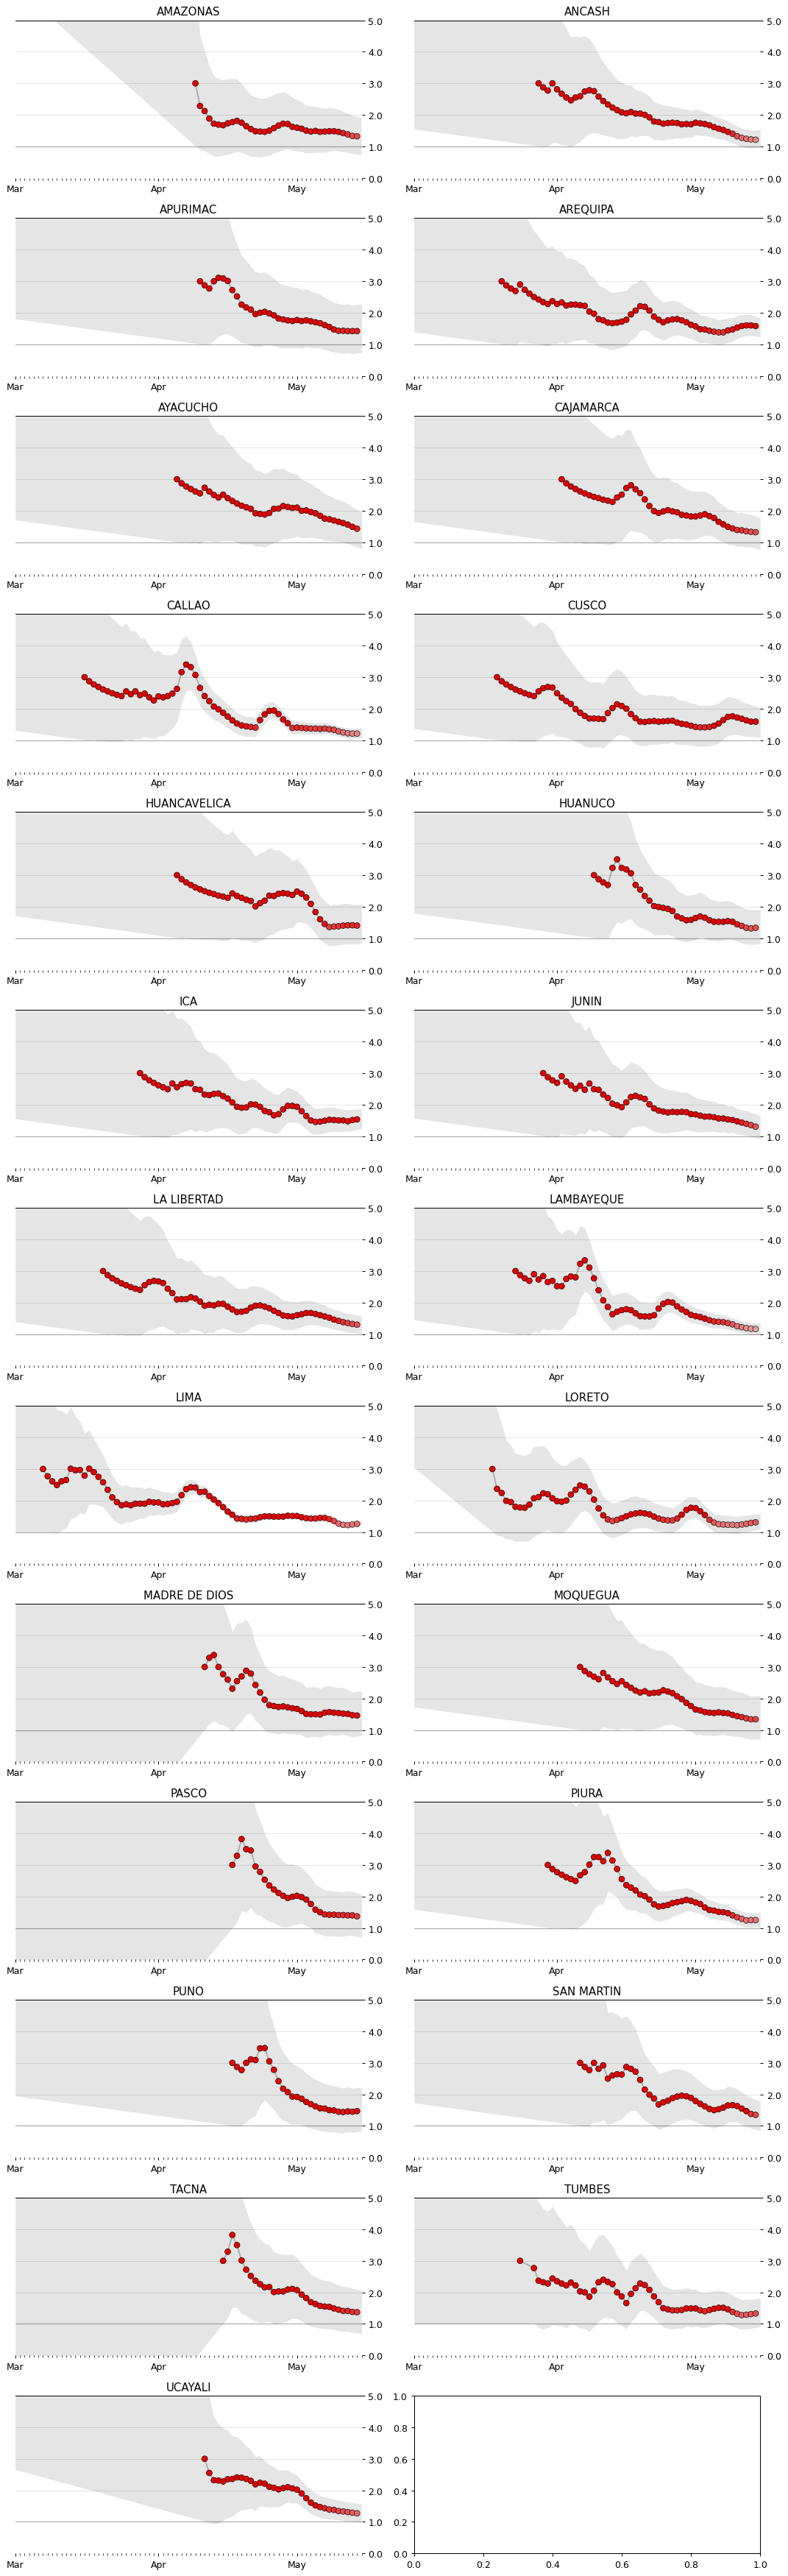

In [0]:
### plotting - Rt vs time for all states ###

def plot_rt_states():

    # number of columns and rows for plotting
    #N_COLS = 5
    N_COLS = 2
    N_ROWS = int(np.ceil(len(results) / N_COLS))

    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(12, N_ROWS*3), dpi=90)

    # loop for several states
    for i, (state_name, result) in enumerate(final_results.groupby('state')):
        plot_rt(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

plot_rt_states()

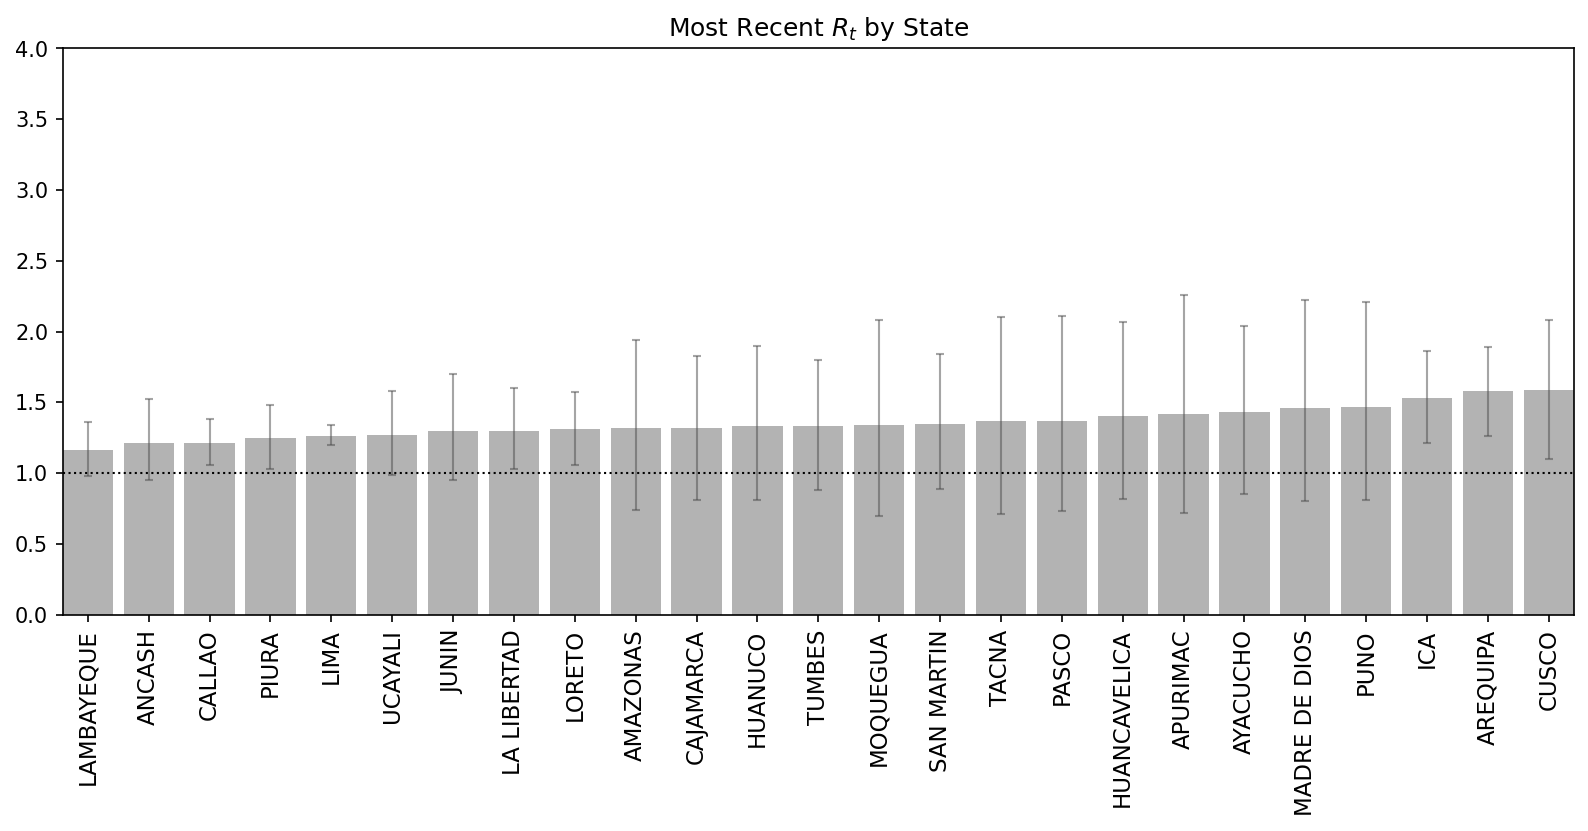

In [0]:
### plotting - state comparison ###

mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr.sort_values('ML', inplace=True)
plot_standings(mr, figsize=(13,5));

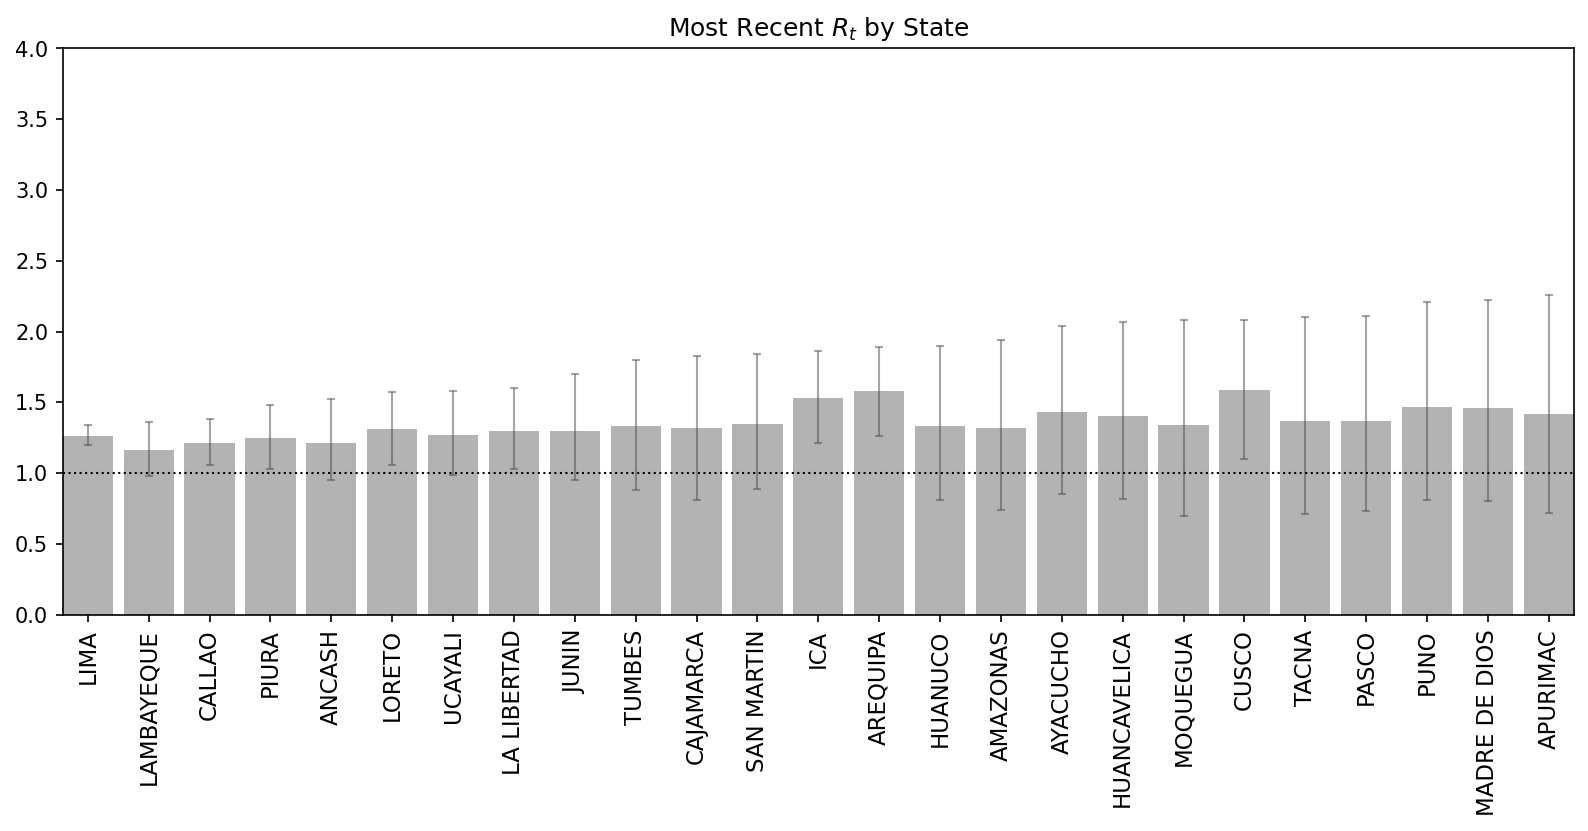

In [0]:
### ordering by worst case ##

mr.sort_values('High_90', inplace=True)
plot_standings(mr, figsize=(13,5));

In [0]:
final_results.to_csv('final_results.csv')